In [1]:
import sys
sys.path.append('E:/PythonPackages')
import os
import torch
import torchvision
from torchvision import models, transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


In [2]:
device ="cuda" if torch.cuda.is_available() else "cpu"

In [3]:
log_file = open('log_file.txt', 'w')

In [4]:
# sys.stdout = log_file

In [5]:
data_dir = 'C:/mini-project-gnr/CUB_200_2011/images/'

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

# Split dataset into train and test
train_size = int(0.6 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [6]:
class ModifiedResNet18(nn.Module):
    def __init__(self, num_classes=200): 
        super(ModifiedResNet18, self).__init__()
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual blocks
        self.layer1 = self._make_layer(32, 32, blocks=2, stride=1)
        self.layer2 = self._make_layer(32, 64, blocks=2, stride=2)
        self.layer3 = self._make_layer(64, 128, blocks=2, stride=2)
        self.layer4 = self._make_layer(128, 256, blocks=2, stride=2)

        # Average pool and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes) 

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x) 

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
        
class ResidualBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        # Add the shortcut (skip connection) to the output of the layers
        shortcut = self.shortcut(x)

        out += shortcut
        out = self.relu(out)
        return out


net = ModifiedResNet18()
net = net.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))


In [7]:
from torchsummary import summary

# Create a dummy input with the same shape as the expected input
dummy_input = torch.randn(1, 3, 224, 224)  # Assuming input size is 224x224

# Use torchsummary to summarize the model
summary(net, input_size=dummy_input.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]           4,704
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
         MaxPool2d-4           [-1, 32, 56, 56]               0
            Conv2d-5           [-1, 32, 56, 56]           9,216
       BatchNorm2d-6           [-1, 32, 56, 56]              64
              ReLU-7           [-1, 32, 56, 56]               0
            Conv2d-8           [-1, 32, 56, 56]           9,216
       BatchNorm2d-9           [-1, 32, 56, 56]              64
             ReLU-10           [-1, 32, 56, 56]               0
    ResidualBlock-11           [-1, 32, 56, 56]               0
           Conv2d-12           [-1, 32, 56, 56]           9,216
      BatchNorm2d-13           [-1, 32, 56, 56]              64
             ReLU-14           [-1, 32,

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [9]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [10]:
# sys.stdout = sys.__stdout__
# log_file.close()

In [11]:
num_epochs = 30
train_losses = []  
train_accuracies = [] 
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
     
    for images, labels in train_loader:
        images, labels = images.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu")), labels.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
        
        optimizer.zero_grad()

        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    
    train_losses.append(running_loss / total_train)
    train_accuracies.append(100 * correct_train / total_train)
    
    print(f"Epoch {epoch+1}, Training Loss: {train_losses[-1]}, Training Accuracy: {train_accuracies[-1]}")

print('Finished Training')


Epoch 1, Training Loss: 0.16568245897195996, Training Accuracy: 0.8908371040723982
Epoch 2, Training Loss: 0.15619492092553308, Training Accuracy: 2.0786199095022626
Epoch 3, Training Loss: 0.14885187526633836, Training Accuracy: 3.0118778280542986
Epoch 4, Training Loss: 0.1415379787057773, Training Accuracy: 4.3127828054298645
Epoch 5, Training Loss: 0.1339182592422714, Training Accuracy: 5.896493212669683
Epoch 6, Training Loss: 0.12621298476177104, Training Accuracy: 8.79524886877828
Epoch 7, Training Loss: 0.1168067765114534, Training Accuracy: 12.471719457013574
Epoch 8, Training Loss: 0.10929018815313529, Training Accuracy: 16.43099547511312
Epoch 9, Training Loss: 0.10088828418454433, Training Accuracy: 20.9841628959276
Epoch 10, Training Loss: 0.09257651808170173, Training Accuracy: 24.90101809954751
Epoch 11, Training Loss: 0.08631974596917899, Training Accuracy: 29.920814479638008
Epoch 12, Training Loss: 0.07737295437452481, Training Accuracy: 35.39309954751131
Epoch 13, Tr

In [12]:
import matplotlib.pyplot as plt

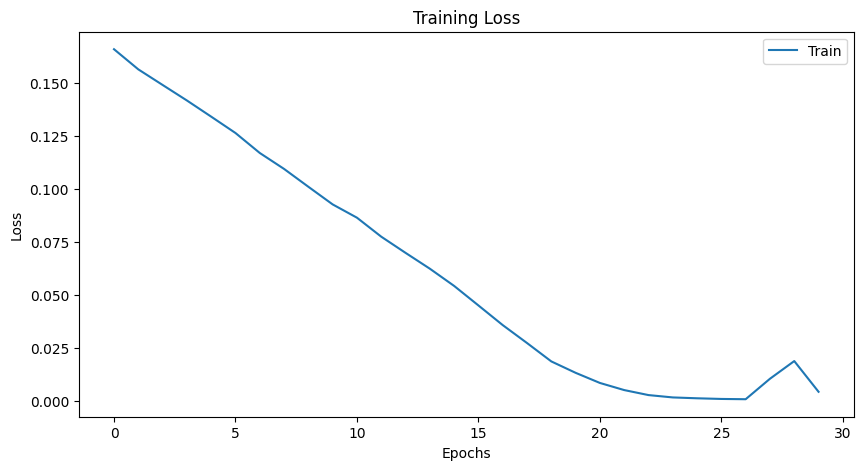

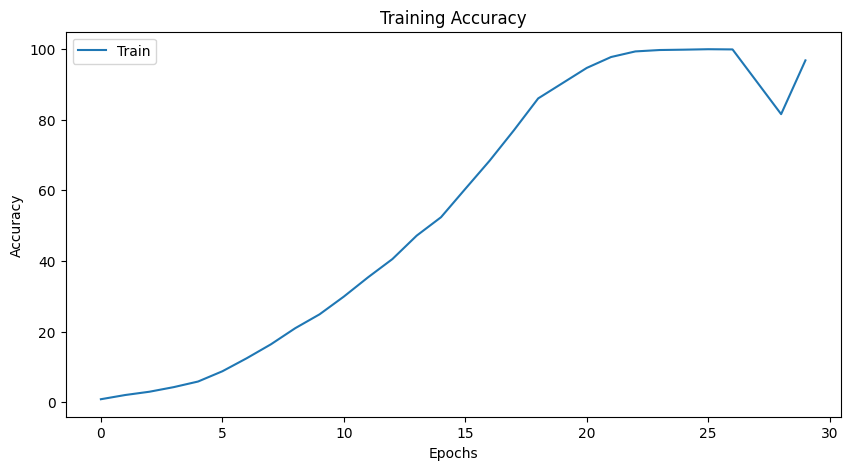

In [17]:
# Plotting training and validation loss
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(train_losses,label="Train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10,5))
plt.title("Training Accuracy")
plt.plot(train_accuracies,label="Train")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu")), labels.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total}%')


Accuracy of the network on the test images: 26.95080576759966%


In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        images, labels = images.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu")), labels.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the train images: {100 * correct / total}%')

Accuracy of the network on the train images: 99.43438914027149%


In [16]:

def check_accuracy(loader, model):
    num_right = 0
    num_samp = 0
    model.eval()  

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)  
            labels = labels.to(device)

            scores = model(inputs)
            _, predictions = scores.max(1)
            num_right += (predictions == labels).sum().item()
            num_samp += labels.size(0)

        accuracy = 100.0 * num_right / num_samp
        print(f"Got {num_right} correct images out of {num_samp} total images ({accuracy:.2f}% accuracy)")

    model.train()  # Set model back to training mode


check_accuracy(train_loader, net)
check_accuracy(test_loader, net)


Got 7066 correct images out of 7072 total images (99.92% accuracy)
Got 1351 correct images out of 4716 total images (28.65% accuracy)
